In [1]:
import pandas as pd
import numpy as np
from capsubot_env.capsubot import Capsubot
from capsubot_env.capsubot_env_to_point import CapsubotEnvToPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from brute_mpc import *


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%matplotlib inline
import pickle

force_encodings=make_force_encodings(5)
fixed_T=0.0441
model_type = 1
frame_skip = int(0.01/MIN_DT)
print(frame_skip)
agent = Capsubot(dt=MIN_DT, frame_skip=frame_skip, model=model_type)
data = {"states" : [], "actions" : [], "timestamps" : []}
idx = 0
while agent.get_total_time < 2.0:
    if idx < 2:
        force = calculate_mpc_force(current_state=agent.get_state, duration=0.1, model_type=model_type, T=fixed_T, total_time=agent.get_total_time)
        idx += 0
    agent.step_force(unit_force=force)

    data["states"].append(agent.get_state)
    data["actions"].append(force(agent.get_total_time))
    data["timestamps"].append(agent.get_total_time)
    print(agent.get_total_time)
    with open('data.pkl', 'wb') as fp:
        pickle.dump(data, fp)


200
tau 0.28500000000000003
[0.0029601949081544685, 0.28500000000000003, 1] 0.9999988831232063 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd66f3d820>
0.009999999999999967
tau 0.275
[0.005017826693188196, 0.275, 1] 0.9999988425095048 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd1676b3a0>
0.02000000000000006
tau 0.275
[0.007340513926535866, 0.275, 1] 0.9999988425095048 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd66f5dca0>
0.030000000000000346
tau 0.26
[0.006483578302365661, 0.26, 1] 0.999998775731207 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd66f3d790>
0.04000000000000063
tau 0.22
[0.006005609371516944, 0.22, 1] 0.999998553136881 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd66f3d820>
0.05000000000000092
tau 0.22
[0.0070246182252665995, 0.22, 1] 0.999998553136881 <function calculate_mpc_force.<locals>.<lambda> at 0x7fcd66f5dca0>
0.060000000000001205
tau 0.24
[0.009822723281479625, 0.24, 1] 0.9999986737088076 <function calculat

In [3]:
def make_first_ts_zero(df):
    df["total_times"] -= df["total_times"].iloc[0]

In [8]:
rl_model_df = pd.read_csv("../data/data_max_speed.csv")
rl_model_df["total_times"] -= rl_model_df["total_times"].iloc[0]
classic_model_df = pd.read_csv("../data/data_max_speed_classic_control.csv")
classic_model_df["total_times"] -= classic_model_df["total_times"].iloc[0]
rl_model = CapsubotEnvToPoint()
omega = np.sqrt(rl_model.agent._stiffness*(rl_model.agent._M + rl_model.agent._m)/rl_model.agent._M/rl_model.agent._m)
L = rl_model.agent._force_max/rl_model.agent._stiffness

In [9]:
classic_model_df.head()

,Unnamed: 0,actions,total_times,positions,speeds
0,0,1,0.00000,0.000000e+00,0.000000
1,1,1,0.00025,-9.283364e-08,-0.000250
2,2,1,0.00050,-1.814223e-07,0.000165
3,3,1,0.00075,-2.340264e-07,-0.000775
4,4,1,0.00100,-3.190812e-07,-0.000365


In [10]:
rl_model_df.head()

,Unnamed: 0,actions,total_times,positions,speeds
0,0,0,0.00000,0.0,0.0
1,1,0,0.00025,0.0,0.0
2,2,0,0.00050,0.0,0.0
3,3,0,0.00075,0.0,0.0
4,4,0,0.00100,0.0,0.0


In [11]:
df = classic_model_df
increase_accuracy=40
agent = Capsubot((df["total_times"].iloc[1] - df["total_times"].iloc[0])/increase_accuracy, frame_skip=increase_accuracy)
agent.reset()
states = []
first = True
for idx, row in df.iterrows():
    if first:
        first = False
        continue
    action, t, pos = row['actions'], row['total_times'], row["positions"]
    agent.step(action=action)
    states.append(agent.get_state[0])

print(f"final states: t/pos { {df['total_times'].iloc[-1]}}/{df['positions'].iloc[-1]}, {agent._total_time}/{states[-1]}")
print(f"average_speed : {states[-1]/agent._total_time}")

final states: t/pos {24.669750000257185}/0.3003884242887413, 24.669749998284637/0.09854063867001019
average_speed : 0.003994391458237802


In [12]:
df = classic_model_df
increase_accuracy=40
agent = Capsubot((df["total_times"].iloc[1] - df["total_times"].iloc[0])/increase_accuracy, frame_skip=increase_accuracy)
agent.reset()
states = []
first = True
T, tau = 100E-3, 0.2

def F_e(t, T, tau):
    """
    Defines electromagnteic force of coil
    """
    return (1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*10.E5))/2.

for idx, row in df.iterrows():
    if first:
        first = False
        continue
    action, t, pos = row['actions'], row['total_times'], row["positions"]
    calc_action = F_e(t, T=T, tau=tau)
    #print(action, calc_action)
    agent.step(action=calc_action)
    states.append(agent.get_state[0])

print(f"final states: t/pos { {df['total_times'].iloc[-1]}}/{df['positions'].iloc[-1]}, {agent._total_time}/{states[-1]}")
print(f"average_speed : {states[-1]/agent._total_time}")

final states: t/pos {24.669750000257185}/0.3003884242887413, 24.669749998284637/0.18682153832696008
average_speed : 0.0075728995364748464


In [16]:
df = classic_model_df
states = []
first = True
agent = Capsubot(dt=0.01/200, frame_skip=1, model=0)
omega = agent.omega
L = agent.L
agent.reset()

def F_e(t, T, tau):
    """
    Defines electromagnteic force of coil
    """
    return (1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*10.E5))/2.

speed = []

T = 0.100
for tau in tqdm(np.linspace(0, 0.5, 11)):    
    agent.reset()
#     tau = 0.215
    while agent._total_time <= T*50:
        action = F_e(agent._total_time, T=T, tau=tau)
        #print(agent._total_time, action, agent.get_state[0])
        agent.step(action=action)
        states.append(agent.get_state[0])
#     break
    speed.append(agent._state[0]/agent._total_time)

print(f"final states: t/pos { {df['total_times'].iloc[-1]}}/{df['positions'].iloc[-1]}, {agent._total_time}/{states[-1]}")
av_speed = agent._state[0]/agent._total_time
print(f"average_speed : {av_speed}")
print(f"dimless_average_speed : {av_speed/(L*omega)}")

100%|██████████| 11/11 [00:08<00:00,  1.23it/s]

final states: t/pos {24.669750000257185}/0.3003884242887413, 5.000049999995016/-0.0005293362307339327
average_speed : -0.0001058661874850172
dimless_average_speed : -0.0003135459043716747


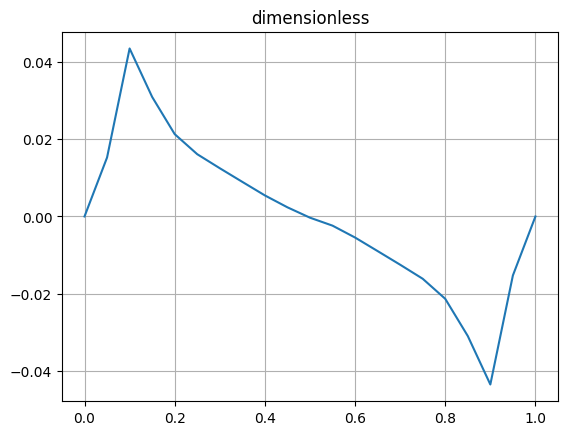

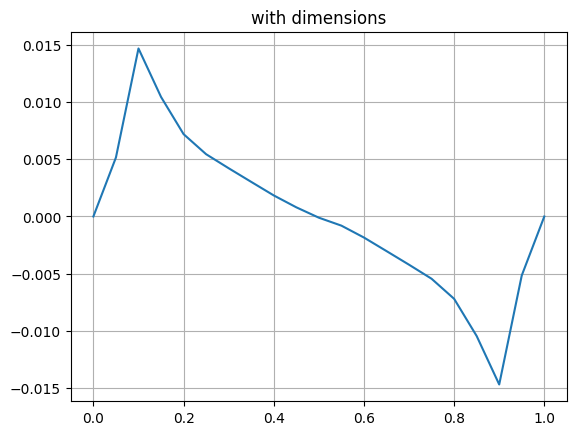

In [17]:
dim_speed = np.array(speed)/omega/L
full_speed = np.append(dim_speed, -np.flip(dim_speed)[1:])
plt.plot(np.linspace(0, 1.0, full_speed.shape[0]), full_speed)
plt.grid()
plt.title("dimensionless")

plt.figure()
full_speed = np.append(speed, -np.flip(speed)[1:])
plt.plot(np.linspace(0, 1.0, full_speed.shape[0]), full_speed)
plt.title("with dimensions")
plt.grid()

In [29]:
# Generate all possible forces with fixed number of switches
def add_switch(value : int, array : list, max_len : int, arrays : List[List]):
    if value != -1:
        array.append(value)
    if len(array) == max_len:
        # print(array)
        arrays.append(array.copy())
        return
    add_switch(0, array, max_len, arrays)
    array.pop()
    add_switch(1, array, max_len, arrays)
    array.pop()

def make_force_encodings(num_switches : int):
    force_encodings = []
    temp = []
    add_switch(-1, temp, num_switches, force_encodings)
    return force_encodings



force_encodings = make_force_encodings(num_switches=3)
# print(periodic_actions)
print(len(force_encodings))

# 0 0 0 0
# 0 0 0 1
# 0 0 1 0
# 0 0 1 1
# 0 0 0 0
# 0 0 0 1 

8


In [30]:
states = []
first = True
T = 1.1*2*np.pi/omega
agent = Capsubot(dt=0.01/200, frame_skip=1)
agent.reset()

def F(t, T, force_encoding):
    fraction = t%T/T
    idx = int(fraction*len(force_encoding))
    return force_encoding[idx]

res = dict()
for T_s in np.linspace(0.5, 1.5, 2):
    T = T_s*2*np.pi/omega
    speed = []
    for force_encoding in force_encodings:    
        agent.reset()
        while agent._total_time <= T*2:
            action = F(t=agent._total_time, T=T, force_encoding=force_encoding)
            agent.step(action=action)
            states.append(agent.get_state[0])
        speed.append(agent._state[0]/agent._total_time)
    res[T_s] = speed.copy()

av_speed = agent._state[0]/agent._total_time
print(f"average_speed : {av_speed}")
print(f"dimless_average_speed : {av_speed/(L*omega)}")

average_speed : 0.0007766602674541313
dimless_average_speed : 0.0023002495105712254


dict_keys([0.5, 1.5])


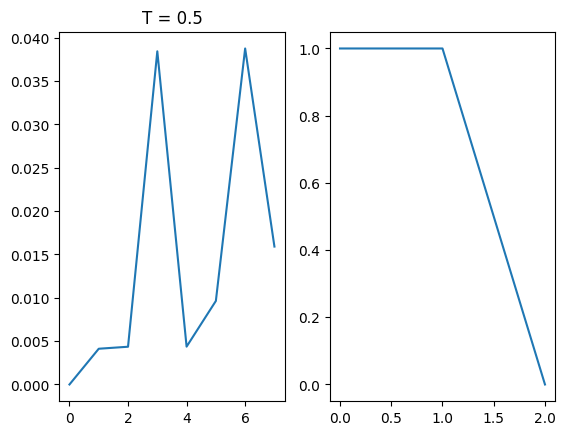

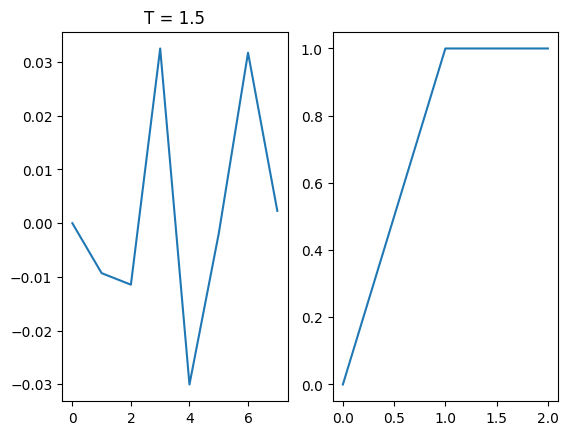

In [31]:
print(res.keys())
for T, speeds in res.items():
    dimless_speed = np.array(speeds)/omega/L
    fig, axs = plt.subplots(ncols=2)
    axs[0].set_title(f"T = {T}")
    axs[0].plot(dimless_speed)
    axs[1].plot(force_encodings[np.argmax(dimless_speed)])

#     plt.figure()
#     plt.plot(force_encodings[np.argmax(dimless_speed)])


In [41]:
sp[T] = [force_encodings, dimless_speed]

dict_keys([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 1.5])


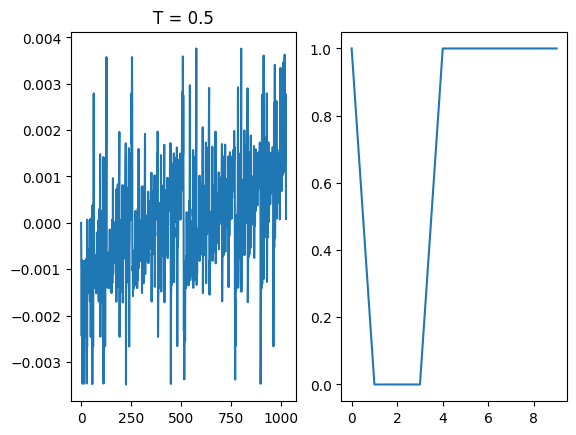

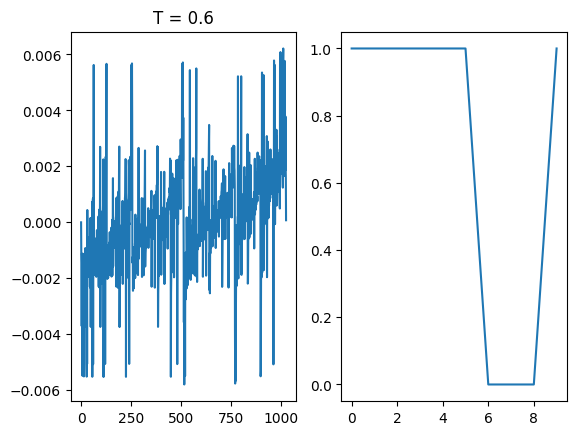

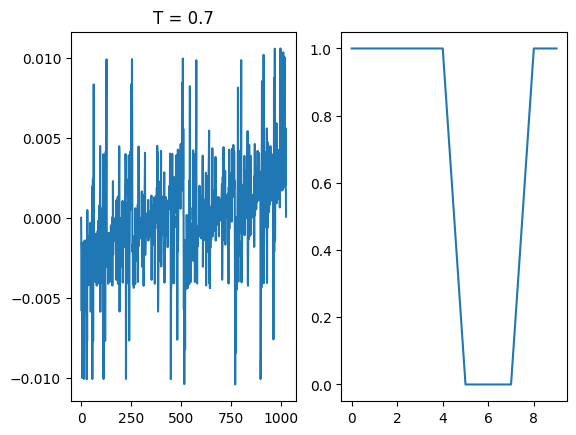

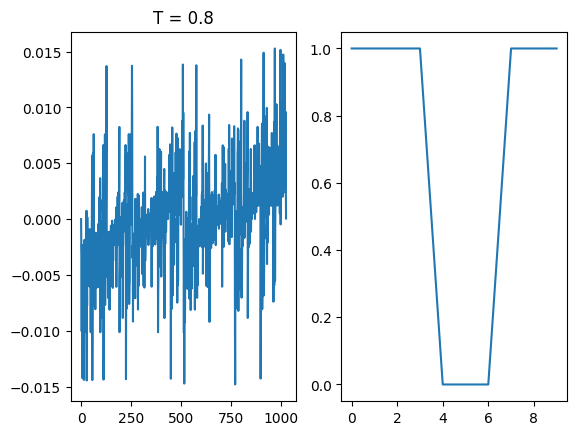

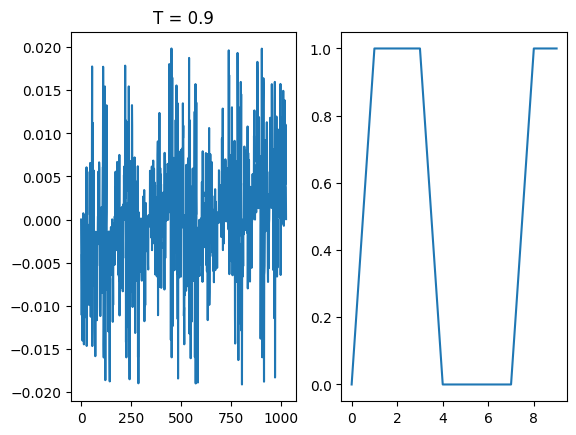

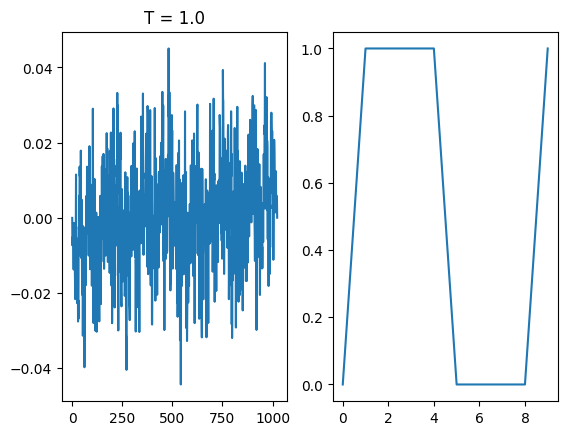

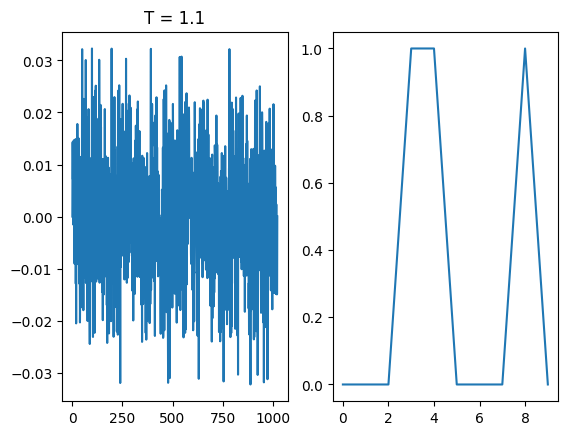

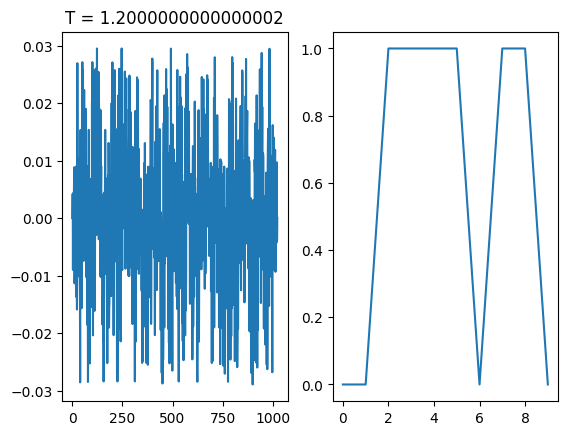

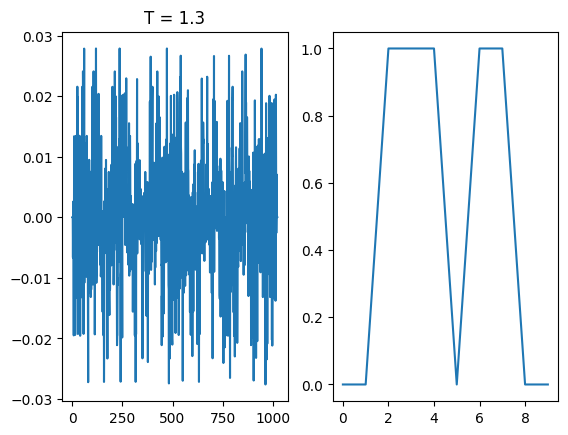

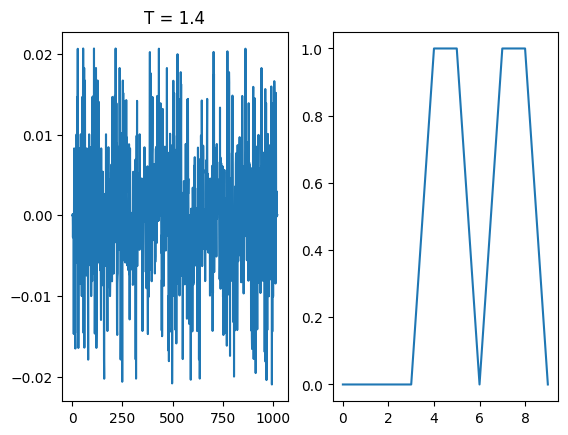

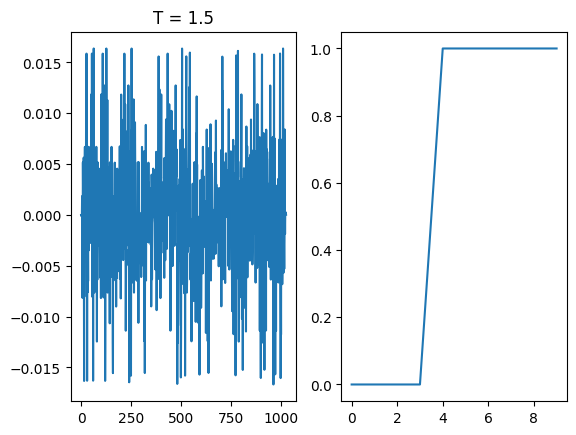

In [27]:
print(res.keys())
for T, speeds in res.items():
    dimless_speed = np.array(speeds)
    fig, axs = plt.subplots(ncols=2)
    axs[0].set_title(f"T = {T}")
    axs[0].plot(dimless_speed)
    axs[1].plot(force_encodings[np.argmax(dimless_speed)])

#     plt.figure()
#     plt.plot(force_encodings[np.argmax(dimless_speed)])


In [43]:
T = 0.1
tau = 0.1
agent = Capsubot(dt=0.01/200, frame_skip=1)
omega = np.sqrt(rl_model.agent._stiffness*(rl_model.agent._M + rl_model.agent._m)/rl_model.agent._M/rl_model.agent._m)
L = rl_model.agent._force_max/rl_model.agent._stiffness

def F(t, T, tau):
    fraction = t%T/T
    return 1.0 if fraction < tau else 0.0

agent.reset()
while agent._total_time <= T*50:
    action = F(agent._total_time, T, tau)
    agent.step(action=action)

    
av_speed = agent._state[0]/agent._total_time
print(f"average_speed : {av_speed}, {agent._total_time}")
print(f"dimless_average_speed : {av_speed/(L*omega)}")

average_speed : 0.014725547408014954, 5.000049999995016
dimless_average_speed : 0.0436129343003635


In [2]:
from brute_mpc import *

In [3]:
force_encodings=make_force_encodings(5)
idx = 5
T = 0.1
force = lambda t : force_from_encoding(t=t, T=T, force_encoding=force_encodings[idx])
state = compute_trajectory(duration=50*T, force_func=force, model_type=1)
agent = Capsubot(dt=MIN_DT, frame_skip=1, model=1)
print(state[1]/state[0])

for force_encoding in force_encodings:
    print(force_encoding)

print(calculate_mpc_action(agent=agent, duration=1.0, force_encodings=force_encodings))

-0.007820428971087966
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 1]
[1, 0, 0, 1, 0]
[1, 0, 0, 1, 1]
[1, 0, 1, 0, 0]
[1, 0, 1, 0, 1]
[1, 0, 1, 1, 0]
[1, 0, 1, 1, 1]
[1, 1, 0, 0, 0]
[1, 1, 0, 0, 1]
[1, 1, 0, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 0]
[1, 1, 1, 0, 1]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
(14, 0.018102929378166672)
0


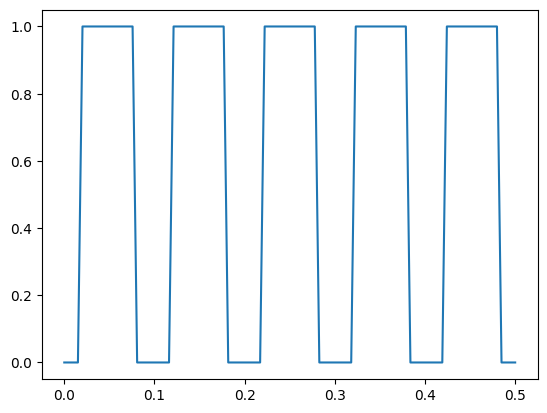

In [8]:
for idx, force_encoding in enumerate(force_encodings):
    if idx != 14:
        continue
    t_space = np.linspace(0., 0.5, 100)
    force = []
    for t in t_space:
        force.append(force_from_encoding(t, 0.1, force_encoding))
    plt.figure()
    plt.plot(t_space, force)

100
optimal action 1 at 0.0
optimal action 1 at 0.0049999999999999975
optimal action 1 at 0.009999999999999967
optimal action 0 at 0.014999999999999937
optimal action 0 at 0.02000000000000006
optimal action 0 at 0.025000000000000203
optimal action 1 at 0.030000000000000346
optimal action 1 at 0.03500000000000049
optimal action 1 at 0.04000000000000063
optimal action 0 at 0.045000000000000775
optimal action 0 at 0.05000000000000092
optimal action 0 at 0.05500000000000106
optimal action 0 at 0.060000000000001205
optimal action 1 at 0.065000000000001
optimal action 1 at 0.07000000000000045
optimal action 1 at 0.0749999999999999
optimal action 0 at 0.07999999999999935
optimal action 0 at 0.0849999999999988
optimal action 0 at 0.08999999999999825
optimal action 0 at 0.0949999999999977
optimal action 1 at 0.09999999999999715
optimal action 1 at 0.1049999999999966
optimal action 1 at 0.10999999999999605
optimal action 0 at 0.1149999999999955
optimal action 0 at 0.11999999999999494
optimal act

In [9]:
states[-1][0]/timestamps[-1]

0.000893802809199618